In [ ]:
import pandas as pd
import matplotlib.pylab as plt
import surprise
import numpy as np
from surprise import Reader
from surprise import Dataset

In [2]:
# Read csv
trade_df = pd.read_csv("./data/trade.csv", encoding="utf-8", parse_dates=['ISSUEDT'],
                       dtype={'HSCD': str, "QTY": float, 'BYRADDR2': str, 'SPLYADDR2': str})

In [3]:
trade_df = trade_df[['BYRORGNM1', 'SPLYORGNM1']]

In [4]:
df = trade_df.groupby(['BYRORGNM1', 'SPLYORGNM1']).agg('size').reset_index()

In [5]:
df.columns = ['byr', 'spl', 'trd_cnt']

In [ ]:
df.groupby('byr').agg('size').sort_values().reset_index().groupby(0).agg('size').sum()

In [ ]:
df.groupby('byr').agg('size').sort_values().reset_index().groupby(0).agg('size').loc[50:].sum()

In [6]:
b = df['byr'].value_counts() >= 5
b = b[b].index.tolist()

In [7]:
s = df['spl'].value_counts() >= 5
s = s[s].index.tolist()

In [8]:
df = df.loc[(df['byr'].isin(b)) & (df['spl'].isin(s))].reset_index(drop=True)

In [ ]:
df.head()

In [ ]:
df.groupby('trd_cnt').agg('size').sum()

In [ ]:
df.groupby('trd_cnt').agg('size').loc[111:].sum()

In [9]:
import sys
rating = {1:[1,1], 2:[2,2], 3:[3,3], 4:[4,4], 5:[5,6],
          6:[7,9], 7:[10,16], 8:[17,35], 9:[30,110], 10:[111,sys.maxsize]}

In [10]:
for i in rating:
    df.loc[(df.trd_cnt >= rating[i][0]) & (df.trd_cnt <= rating[i][1]), 'trd_cnt'] = i    

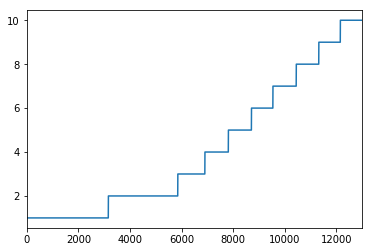

In [11]:
df.sort_values('trd_cnt').trd_cnt.reset_index(drop=True).plot()

In [ ]:
df.head()

In [12]:
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(df, reader)

In [ ]:
from surprise.model_selection import cross_validate
bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
algo = surprise.BaselineOnly(bsl_options)
cross_validate(algo, data)

In [13]:
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,fit_time,test_rmse,test_time
Algorithm,,,
SVDpp,1.845502,2.260148,0.090141
SVD,0.339768,2.293707,0.021790
BaselineOnly,0.012978,2.359879,0.014268
KNNBaseline,0.086455,2.479168,0.068057
KNNWithMeans,0.101032,2.499003,0.052583
KNNWithZScore,0.164734,2.537946,0.055625
NMF,0.660210,2.591023,0.018895
SlopeOne,0.076498,2.599011,0.053147
CoClustering,0.405374,2.635818,0.019142


In [ ]:
%%time
algo = surprise.SVD(n_factors=100)
cross_validate(algo, data)["test_mae"].mean()

In [14]:
from surprise.model_selection import train_test_split
from surprise import accuracy
trainset, testset = train_test_split(data, test_size=0.25)
algo = surprise.SVD(n_factors=100)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 2.2648


2.264824006982481

In [15]:
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

rcm_df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
rcm_df['Iu'] = rcm_df.uid.apply(get_Iu)
rcm_df['Ui'] = rcm_df.iid.apply(get_Ui)
rcm_df['err'] = abs(rcm_df.est - rcm_df.rui)

In [16]:
rcm_df.sort_values(by='err').head(10)

,uid,iid,rui,est,details,Iu,Ui,err
514,현대자동차,대동도어주식회사,10.0,10.000000,{'was_impossible': False},140,5,0.000000
2110,현대자동차,(주)동보,10.0,10.000000,{'was_impossible': False},140,5,0.000000
2767,현대자동차,주식회사 경신,10.0,10.000000,{'was_impossible': False},140,3,0.000000
2991,현대자동차,한온시스템(주),10.0,10.000000,{'was_impossible': False},140,3,0.000000
1162,삼성전자(주),삼화콘덴서공업(주),10.0,10.000000,{'was_impossible': False},67,9,0.000000
2599,현대자동차,콘티넨탈오토모티브시스템(주),10.0,10.000000,{'was_impossible': False},140,5,0.000000
2076,현대자동차,케이비와이퍼시스템 주식회사,10.0,10.000000,{'was_impossible': False},140,4,0.000000
1029,(주)비씨아이엔티,몽고식품(주)창원1공장,5.0,4.997524,{'was_impossible': False},9,14,0.002476
209,(주)아이티에스코리아,주식회사 씨더블유,3.0,3.002616,{'was_impossible': False},5,3,0.002616
3242,(주)에스앤디페브릭,(주)영신물산,3.0,2.996309,{'was_impossible': False},8,9,0.003691


In [17]:
rcm_df.sort_values(by='err').tail(10)

,uid,iid,rui,est,details,Iu,Ui,err
703,주식회사한나코퍼레이션,상신브레이크(주),10.0,4.293440,{'was_impossible': False},2,5,5.706560
2631,현대중공업(주),(주)아이피케이,2.0,7.764435,{'was_impossible': False},24,6,5.764435
3218,(주)태웅,(주)태상,10.0,4.232944,{'was_impossible': False},0,7,5.767056
1404,삼성디스플레이(주),주식회사 이녹스첨단소재,1.0,6.783114,{'was_impossible': False},14,5,5.783114
3013,현대글로비스(주),선진섬유공업사,2.0,7.962010,{'was_impossible': False},137,3,5.962010
772,희성전자(주),한국쓰리엠(주),10.0,4.011402,{'was_impossible': False},3,8,5.988598
700,코리아실크로드,(주)현대화섬,9.0,2.994061,{'was_impossible': False},5,21,6.005939
1996,(주)위너텍코리아,드림테크,10.0,3.916859,{'was_impossible': False},0,2,6.083141
70,동양이엔피 주식회사,(주)한성피앤아이,1.0,7.225014,{'was_impossible': False},28,4,6.225014
2512,(주)두산양행,삼강통산(주),9.0,2.692350,{'was_impossible': False},16,13,6.307650


<IPython.core.display.Javascript object>


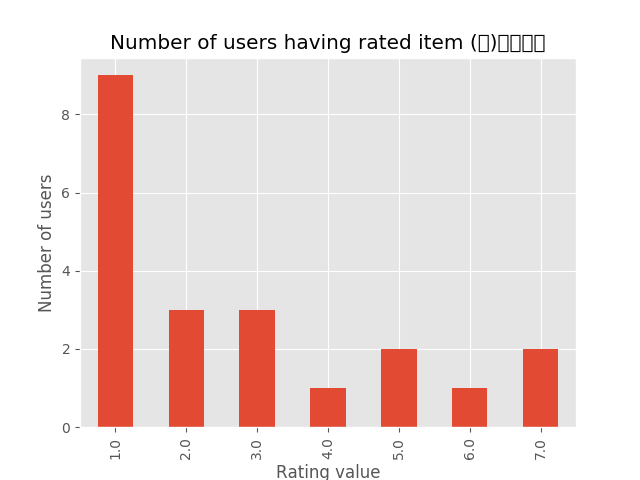

Text(0.5, 1.0, 'Number of users having rated item (주)현대화섬')

In [19]:
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('ggplot')

counter = Counter([r for (_, r) in trainset.ir[trainset.to_inner_iid('(주)현대화섬')]])
pd.DataFrame.from_dict(counter, orient='index').plot(kind='bar', legend=False)
plt.xlabel('Rating value')
plt.ylabel('Number of users')
plt.title('Number of users having rated item (주)현대화섬')

### TEST Rating before drop few ratings (trd_cnt)

In [ ]:
df.groupby('trd_cnt').agg('size').sum()

In [ ]:
df.groupby('trd_cnt').agg('size').loc[701:].sum()

In [ ]:
import sys
rating = {1:[1,1], 2:[2,2], 3:[3,4], 4:[5,7], 5:[8,12], 
          6:[13,23], 7:[24,50], 8:[51,160], 9:[161,700], 10:[701,sys.maxsize]}

In [ ]:
21477 + 13957 + 10439 + 6577 + 5284 + 4303 + 3603 + 2929 + 1634 + 589

In [ ]:
for i in rating:
    df.loc[(df.trd_cnt >= rating[i][0]) & (df.trd_cnt <= rating[i][1]), 'trd_cnt'] = i    

In [ ]:
df.head()

In [ ]:
df.groupby('trd_cnt').agg('size').plot.bar()

In [ ]:
df.head()

In [ ]:
df.groupby('byr').agg('size').sort_values(ascending=False)[:10].plot()

### Make Surprise Data from Dataframe

In [ ]:
reader = Reader(rating_scale=(1,10))

In [ ]:
data = Dataset.load_from_df(df, reader)

In [ ]:
from surprise.model_selection import cross_validate
bsl_options = {
    'method': 'als',
    'n_epochs': 5,
    'reg_u': 12,
    'reg_i': 5
}
algo = surprise.BaselineOnly(bsl_options)
cross_validate(algo, data)

## By AMT

In [ ]:
trade_df[['BYRORGNM1', 'SPLYORGNM1', 'AMT', 'CUR']].head()

In [ ]:
trade_df = trade_df[['BYRORGNM1', 'SPLYORGNM1', 'AMT', 'CUR']]

In [ ]:
trade_df.CUR.drop_duplicates()

In [ ]:
trade_df = trade_df.loc[(trade_df.CUR == "USD") | (trade_df.CUR == "KRW")]

In [ ]:
trade_df.loc[trade_df.CUR == 'USD'].head()

In [ ]:
trade_df.loc[trade_df.CUR == 'KRW'].head()

In [ ]:
def calculate_krw(amt: float, cur: str) -> float:
    if cur == 'KRW':
        return amt
    elif cur == 'USD':
        return amt * 1244

In [ ]:
trade_df['AMT_KRW'] = trade_df.apply(lambda x: calculate_krw(x['AMT'], x['CUR']), axis=1)

In [ ]:
trade_df.loc[[0, 35800]]

In [ ]:
df = trade_df[['SPLYORGNM1', 'BYRORGNM1', 'AMT_KRW']]

In [ ]:
df.head()

In [ ]:
df = df.groupby(['SPLYORGNM1', 'BYRORGNM1']).agg('sum').sort_values('AMT_KRW', ascending=False).reset_index()

In [ ]:
df.head()

In [ ]:
df.columns = ['spl', 'byr', 'krw']

In [ ]:
df.shape

In [ ]:
df_table = df.set_index(["spl", "byr"]).unstack()
df_table.shape

In [ ]:
plt.imshow(df_table)
plt.grid(False)
plt.xlabel("byr")
plt.ylabel("spl")
plt.title("Trade Matrix")
plt.show()

In [ ]:
list(df_table.index).index('POSCO')

In [ ]:
val = '주식회사 포스코대우'
[(index, row.index(val)) for index, row in enumerate(list(df_table.columns)) if val in row]

In [ ]:
df_table.iloc[13660:13670, 13740:13750]

In [ ]:
df_table.count(axis=1).sort_values(ascending=False)[:100].plot.box

In [ ]:
plt.imshow(df_table.loc[df_table.count(axis=1).sort_values(ascending=False)[:100].index])
plt.grid(False)
plt.xlabel("byr")
plt.ylabel("spl")
plt.title("Trade Matrix")
plt.show()

In [ ]:
plt.imshow(df_table.iloc[13660:13670, 13740:13750])
plt.grid(False)
plt.xlabel("byr")
plt.ylabel("spl")
plt.title("Trade Matrix")
plt.show()

In [ ]:
df_table.count(axis=0).sort_values(ascending=False)

## Make dataframe to surprise dataset

In [ ]:
df.krw.max()

In [ ]:
df.krw.min()

In [ ]:
from surprise import Reader
from surprise import Dataset

In [ ]:
reader = Reader(rating_scale)

In [ ]:
df.head()

In [ ]:
df.krw.max()

In [ ]:
reader=Reader(rating_scale=(0, 5))

In [ ]:
df

In [ ]:
df.krw = df.krw / df.krw.max() * 5.0

In [ ]:
data = Dataset.load_from_df(df[['spl', 'byr', 'krw']], reader=reader)

In [ ]:
data.raw_ratings

In [ ]:
from surprise.model_selection import KFold

bsl_options = {
    'method': 'als',
    'n_epochs': 500,
    'reg_u': 12,
    'reg_i': 5
}
algo = surprise.BaselineOnly(bsl_options)

np.random.seed(0)
acc = np.zeros(3)
cv = KFold(3)
for i, (trainset, testset) in enumerate(cv.split(data)):
    algo.fit(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.rmse(predictions, verbose=True)
acc.mean()

In [ ]:
from surprise.model_selection import cross_validate

sim_options = {'name': 'msd'}
algo = surprise.KNNBasic(sim_options=sim_options)
cross_validate(algo, data)["test_mae"].mean()

In [ ]:
data_ml = surprise.Dataset.load_builtin('ml-100k')

In [ ]:
data.raw_ratings

In [ ]:
data_ml.raw_ratings

# Trade count

In [ ]:
df = trade_df[['BYRORGNM1', 'SPLYORGNM1']]

In [ ]:
df = df.groupby(['BYRORGNM1', 'SPLYORGNM1']).agg('size').reset_index()

In [ ]:
df.head()

In [ ]:
df.columns = ['byr', 'spl', 'trd_cnt']

In [ ]:
df.head()

In [ ]:
df.sort_values('trd_cnt').trd_cnt.reset_index(drop=True).plot()

In [ ]:
len(df.loc[df.trd_cnt < 3])

In [ ]:
len(df.loc[df.trd_cnt <= 14])

In [ ]:
df.sort_values('trd_cnt').trd_cnt.reset_index(drop=True)[35434:58914].plot.box()

In [ ]:
df.sort_values('trd_cnt').trd_cnt.reset_index(drop=True)[35434:58914].plot()

In [ ]:
df = df.sort_values('trd_cnt')[35434:58914].reset_index(drop=True)

In [ ]:
df.tail()

In [ ]:
df.groupby('spl').agg('size').sort_values().plot()

In [ ]:
df.groupby('spl').agg('size').sort_values().tail()

In [ ]:
df.groupby('spl').agg('size').plot.box()

In [ ]:
# refer: https://nbviewer.jupyter.org/github/NicolasHug/Surprise/blob/master/examples/notebooks/KNNBasic_analysis.ipynb